## Model 5: SVM
* ~~Logistic Regression~~
* ~~Random Forest~~
* ~~Naïve Bayes~~
* <b><i>SVM</b></i>

### Model Performance Summary

Overfit, but accuracy is comparable to best model so far _(Count Vectorizer, Naïve Bayes)._

Baseline: `0.5074`

Model   | Transformer       | Classifier            | $n$  | x-val   | Train    | Test   |  Precision    | Specificity  | Recall
---     |---                | ---                   | ---  | ---     | ---      | ---    |  ---          | ---          | ---
1*      | Count Vectorizer  | Logistic Regressor    | 2605 | 0.7373  | 0.9723   | 0.7515 | 0.7436        | 0.7179       | 0.7838 
2*      | Count Vectorizer  | Logistic Regressor    | 4537 | 0.7111  | 0.9568   | 0.7436 | 0.7527        | 0.7496       | 0.7396
3       | Count Vectorizer  | Random Forest	        | 4537 | 0.7569  | 0.9855   | 0.7154 | 0.7126        | 0.696        | 0.7325
4       | Count Vectorizer  | Naïve Bayes	        | 4537 | 0.7587  | 0.8628   | 0.7722 | 0.7682        | 0.7536       | 0.7937 
5       | TF-IDF            | SVM                   | 4537 | 0.7834  | 0.9793   | 0.7509 | 0.7496        | 0.7374       | 0.764


In [1]:
##### BASIC IMPORTS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### MODELLING IMPORTS 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC

##### VECTOR MODELLING IMPORTS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.feature_extraction import text   # TO MODIFY STOP WORDS 

from nltk.stem import WordNetLemmatizer

In [2]:
# CUSTOM IMPORTS AND SETTINGS 
plt.style.use('gstyle.mplstyle')                        # stylesheet for sns
color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',         # colorlist, color blind pallet
                  '#f781bf', '#a65628', '#984ea3',      # from gist.github.com/thriveth/8560036
                  '#999999', '#e41a1c', '#dede00']

sns.set_palette(sns.color_palette(color_cycle))         # setting custom palette

pd.options.display.max_columns = 90                     # view settings
pd.options.display.max_rows = 100

In [3]:
# importing clean file from model 2
df = pd.read_csv('../data/reddit_2000_clean.csv')
df.dropna(axis=0, inplace = True)
df.shape

(4511, 2)

In [4]:
df.head()

,corpus,class
0,if you look around there are lots of horror st...,1
1,just to close on this tesla replaced the latch...,1
2,it pays to be a tesla owner,1
3,its happening a sub too will try and cross pos...,1
4,dat gullwing mmmm,1


### MODELING

#### Grid and Pipe Setup, Fit, Score

In [5]:
# New Model
X = df['corpus']
y = df['class']

reddit_stopwords = ['porsche', 'tesla', 'taycan', 'model', 'car', 'xplaid', 'turbo']
stopwords = text.ENGLISH_STOP_WORDS.union(reddit_stopwords) 

# train-test split
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X, y, random_state = 42, stratify = y)

pipe = Pipeline([   
    ('tvec', TfidfVectorizer(stop_words = stopwords)),   
    ('svm', SVC()),
])

params = {
    'tvec__max_features': [3000, 4000, 5000, 7000],
    'tvec__min_df': [2, 3, 4],
    'tvec__max_df': [.7,.95],
    'tvec__ngram_range': [(1,1), (1,2),(1,3)],
    'svm__C': [0.1, 0.001, 1],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

# Instantiate GridSearchCV.
gs = GridSearchCV(pipe, params, cv = 3)

# FIT gs 
gs.fit(Xt_train, yt_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [9]:
### all accuracy metrics 
x= ['x-val', 'NB Train', 'NB Test']
model_mets = [ 
    gs.best_score_,                 # estimate with x-val
    gs.score(Xt_train, yt_train),     # train score 
    gs.score(Xt_test, yt_test)      # test score 
     ]
model_mets

[0.740468743772563, 0.9793083062370677, 0.750886524822695]

In [7]:
# model metrics 
x= ['LR Train', 'SVM Train', 'SVM Test', 'LR Test']
model_mets = [0.9855,0.9793083062370677, 0.750886524822695, 0.7154 ]

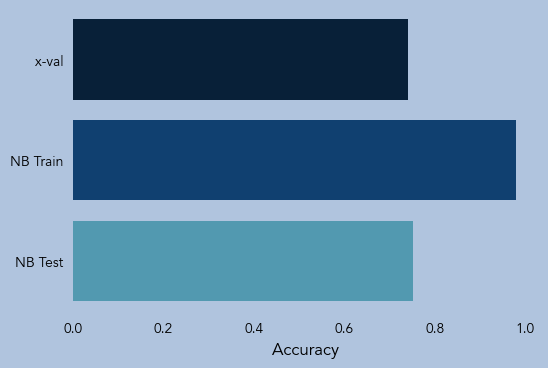

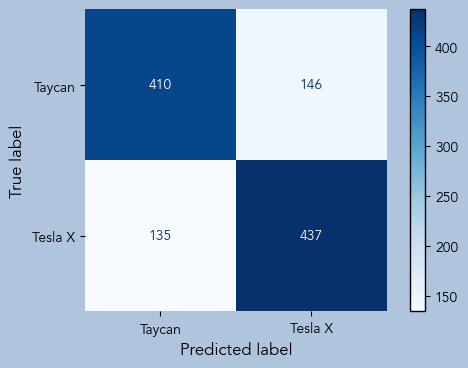

In [10]:
# plot metrics
f, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(bottom=False, left = False)  # remove the ticks
plt.xlabel('Accuracy')

sns.despine(left=True, bottom=True)
sns.barplot(y = x, x = model_mets, palette='ocean')
plt.show()

sub_1 = "Tesla X"
sub_2 = "Taycan"

plot_confusion_matrix(gs, Xt_test, yt_test, cmap = 'Blues', display_labels = [sub_2, sub_1]);
(sns.despine(left=True, bottom=True))

# # Get predictions
preds_tvec = gs.predict(Xt_test)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(yt_test, preds_tvec).ravel()

In [11]:
# precision, specificity, recall 
class_mets = [
    round(tp/(tp + fp), 4),
    round(tn/(tn + fp), 4), 
    round(tp/(tp + fn), 4)
]
class_mets

[0.7496, 0.7374, 0.764]